In [510]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertModel, DistilBertTokenizer, TrainingArguments, Trainer, TrainingArguments
from datasets import load_metric
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
import wandb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib



In [511]:
estimators = 100
do_label_same_size_sample = True
predict_only_one = False
label_to_avoid_predict = "Manual"

# RFC TIMESPLIT

In [512]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas_v2.csv', 
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data entrada','Data vencimento indicada'])  

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'
# Drop specific row with date in year 221
dataFrame = dataFrame[dataFrame['Nº documento Fornecedor'] != "ZRF2 2/6001001951"]

dataFrame['Data Emissão'] = pd.to_datetime(dataFrame['Data Emissão'], format="%d/%m/%Y")
dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")
dataFrame['Data vencimento indicada'] = pd.to_datetime(dataFrame['Data vencimento indicada'], format="%d/%m/%Y")

dataFrame['Valor com IVA'] = dataFrame['Valor com IVA'].str.replace(',', '').astype(float)


In [513]:
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]
dataFrame['Labels'] = dataFrame['Origem']

In [514]:
def select_by_date(group):
    return group.sort_values(by='Data entrada').head(min_size)

if do_label_same_size_sample:
    grouped = dataFrame.groupby('Labels')
    min_size = grouped.size().min()
    dataFrame = grouped.apply(lambda x: x.sample(min_size)).reset_index(drop=True)
    #dataFrame = grouped.apply(select_by_date).reset_index(drop=True)


In [515]:
# Feature Engineering
dataFrame['MonthEmissão'] = dataFrame['Data Emissão'].dt.month
dataFrame['DayEmissão'] = dataFrame['Data Emissão'].dt.day
dataFrame['DayOfWeekEmissão'] = dataFrame['Data Emissão'].dt.dayofweek
dataFrame['YearEmissão'] = dataFrame['Data Emissão'].dt.year


dataFrame['MonthEntrada'] = dataFrame['Data entrada'].dt.month
dataFrame['DayEntrada'] = dataFrame['Data entrada'].dt.day
dataFrame['DayOfWeekEntrada'] = dataFrame['Data entrada'].dt.dayofweek
dataFrame['YearEntrada'] = dataFrame['Data entrada'].dt.year

dataFrame['MonthVencimento'] = dataFrame['Data vencimento indicada'].dt.month
dataFrame['DayVencimento'] = dataFrame['Data vencimento indicada'].dt.day
dataFrame['DayOfWeekVencimento'] = dataFrame['Data vencimento indicada'].dt.dayofweek
dataFrame['YearVencimento'] = dataFrame['Data vencimento indicada'].dt.year

In [516]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

In [517]:
# encode data
label_encoder = LabelEncoder()

dataFrame_before_2024 = dataFrame[dataFrame['Data entrada'] < '2024-02-01']
dataFrame_after_2024 = dataFrame[dataFrame['Data entrada'] >= '2024-02-01']

# REMOVE THIS - ONLY FOR TEMP TEST
if predict_only_one:
    dataFrame_after_2024 = dataFrame_after_2024[dataFrame_after_2024['Labels'] != label_to_avoid_predict]

print("DATA SIZES")
count_contrato = dataFrame_before_2024['Labels'].value_counts().get('Contrato', 0)
count_manual = dataFrame_before_2024['Labels'].value_counts().get('Manual', 0)
print("TRAIN - CONTRATO "+ str(count_contrato))
print("TRAIN - MANUAL "+str(count_manual))

count_contrato_test = dataFrame_after_2024['Labels'].value_counts().get('Contrato', 0)
count_manual_test = dataFrame_after_2024['Labels'].value_counts().get('Manual', 0)
print("TEST - CONTRATO "+ str(count_contrato_test))
print("TEST - MANUAL "+str(count_manual_test))
print("############")

train_labels = dataFrame_before_2024['Labels'].tolist()
test_labels = dataFrame_after_2024['Labels'].tolist()


encoded_labels_train = label_encoder.fit_transform(train_labels)
encoded_labels_test = label_encoder.fit_transform(test_labels)


dataFrame_before_2024 = dataFrame_before_2024.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

dataFrame_before_2024['Fornecedor'] = label_encoder.fit_transform(dataFrame_before_2024['Fornecedor'])
dataFrame_before_2024['Âmbito'] = label_encoder.fit_transform(dataFrame_before_2024['Âmbito'])
dataFrame_before_2024['Tipo'] = label_encoder.fit_transform(dataFrame_before_2024['Tipo'])


dataFrame_after_2024 = dataFrame_after_2024.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

dataFrame_after_2024['Fornecedor'] = label_encoder.fit_transform(dataFrame_after_2024['Fornecedor'])
dataFrame_after_2024['Âmbito'] = label_encoder.fit_transform(dataFrame_after_2024['Âmbito'])
dataFrame_after_2024['Tipo'] = label_encoder.fit_transform(dataFrame_after_2024['Tipo'])



DATA SIZES
TRAIN - CONTRATO 3415
TRAIN - MANUAL 3247
TEST - CONTRATO 382
TEST - MANUAL 550
############


In [518]:
dataFrame_before_2024

,Fornecedor,Valor com IVA,Âmbito,Tipo,MonthEmissão,DayEmissão,DayOfWeekEmissão,YearEmissão,MonthEntrada,DayEntrada,DayOfWeekEntrada,YearEntrada,MonthVencimento,DayVencimento,DayOfWeekVencimento,YearVencimento
1,195,10144.0,16,0,11,10,2,2021,11,26,4,2021,12,10,4,2021
2,426,66925.0,14,0,4,3,0,2023,4,18,1,2023,4,3,0,2023
3,308,18450.0,8,0,3,17,3,2022,3,24,3,2022,4,16,5,2022
4,540,442800.0,8,0,6,14,1,2022,6,15,2,2022,7,14,3,2022
5,698,7288.0,10,0,8,27,4,2021,8,30,0,2021,10,26,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7588,696,86784.0,14,0,1,5,4,2024,1,16,1,2024,3,5,1,2024
7590,509,1658.0,8,0,4,8,4,2022,5,31,1,2022,4,29,4,2022
7591,223,95940.0,5,0,12,10,4,2021,12,17,4,2021,12,10,4,2021
7592,640,332775.0,8,0,1,2,0,2023,2,2,3,2023,2,16,3,2023


In [519]:
# fit model
#model = RandomForestRegressor(n_estimators=estimators, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(dataFrame_before_2024, encoded_labels_train)


# Evaluate random forest regressor
predictions = model.predict(dataFrame_after_2024)

mae = mean_absolute_error(encoded_labels_test, predictions)
print('Mean Absolute Error:', mae)


# Calculate MSE
mse = mean_squared_error(encoded_labels_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(encoded_labels_test, predictions)
print(f'R-squared (R²): {r2}')


# Calculate accuracy
accuracy = sum(1 for true, pred in zip(encoded_labels_test, predictions) if true == pred) / len(encoded_labels_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Mean Absolute Error: 0.28969957081545067
Mean Squared Error (MSE): 0.28969957081545067
R-squared (R²): -0.19771537363160396
Accuracy: 71.03%


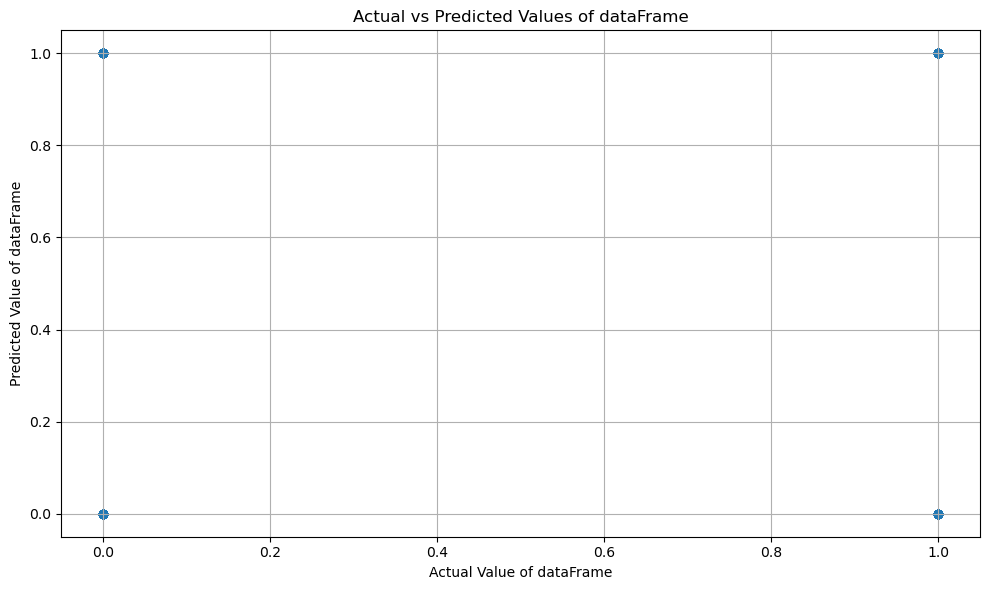

In [520]:
plt.figure(figsize=(10, 6))
plt.scatter(encoded_labels_test, predictions, alpha=0.1)
plt.xlabel('Actual Value of dataFrame')
plt.ylabel('Predicted Value of dataFrame')
plt.title('Actual vs Predicted Values of dataFrame')
plt.grid(True)
plt.tight_layout()
plt.show()

In [521]:
feature_importance = model.feature_importances_
feature_names = dataFrame_before_2024.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Feature Importance:')
print(feature_importance_df)

Feature Importance:
                Feature  Importance
0            Fornecedor    0.282807
1         Valor com IVA    0.192126
2                Âmbito    0.088944
5            DayEmissão    0.086520
13        DayVencimento    0.072281
9            DayEntrada    0.056674
3                  Tipo    0.042470
14  DayOfWeekVencimento    0.026769
6      DayOfWeekEmissão    0.023533
8          MonthEntrada    0.023462
12      MonthVencimento    0.022845
4          MonthEmissão    0.021589
10     DayOfWeekEntrada    0.020776
15       YearVencimento    0.013810
7           YearEmissão    0.012858
11          YearEntrada    0.012536


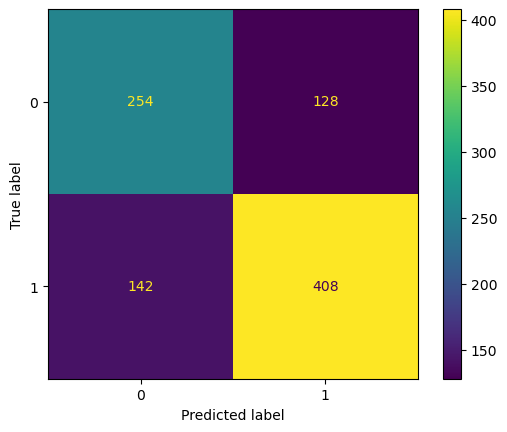

In [522]:
# Generate predictions
y_pred = model.predict(dataFrame_after_2024)

# Compute the confusion matrix
cm = confusion_matrix(encoded_labels_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_) #, display_labels=model.classes_
disp.plot()
plt.show()

In [523]:
# Save the model to a file
joblib.dump(model, 'random_forest_classifier.pkl')

# Load the model from the file
loaded_rfc = joblib.load('random_forest_classifier.pkl')

# Make predictions on the test data using the loaded model
y_pred = loaded_rfc.predict(dataFrame_after_2024)

# Evaluate the loaded model
accuracy = accuracy_score(encoded_labels_test, y_pred)
report = classification_report(encoded_labels_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7103004291845494
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       382
           1       0.76      0.74      0.75       550

    accuracy                           0.71       932
   macro avg       0.70      0.70      0.70       932
weighted avg       0.71      0.71      0.71       932



# RFC NO TIMESPLIT

In [478]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas_v2.csv',
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data vencimento indicada'])

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'
# Drop specific row with date in year 221
dataFrame = dataFrame[dataFrame['Nº documento Fornecedor'] != "ZRF2 2/6001001951"]

dataFrame['Data Emissão'] = pd.to_datetime(dataFrame['Data Emissão'], format="%d/%m/%Y")
dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")
dataFrame['Data vencimento indicada'] = pd.to_datetime(dataFrame['Data vencimento indicada'], format="%d/%m/%Y")

dataFrame['Valor com IVA'] = dataFrame['Valor com IVA'].str.replace(',', '').astype(float)
#dataFrame = pd.get_dummies(dataFrame, columns=['Categoria'])

In [479]:
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]
dataFrame['Labels'] = dataFrame['Origem']

In [480]:
if do_label_same_size_sample:
    grouped = dataFrame.groupby('Labels')
    min_size = grouped.size().min()
    dataFrame = grouped.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

In [481]:
# Feature Engineering
dataFrame['MonthEmissão'] = dataFrame['Data Emissão'].dt.month
dataFrame['DayOfWeekEmissão'] = dataFrame['Data Emissão'].dt.dayofweek
dataFrame['YearEmissão'] = dataFrame['Data Emissão'].dt.year


dataFrame['MonthEntrada'] = dataFrame['Data entrada'].dt.month
dataFrame['DayOfWeekEntrada'] = dataFrame['Data entrada'].dt.dayofweek
dataFrame['YearEntrada'] = dataFrame['Data entrada'].dt.year

dataFrame['MonthVencimento'] = dataFrame['Data vencimento indicada'].dt.month
dataFrame['DayOfWeekVencimento'] = dataFrame['Data vencimento indicada'].dt.dayofweek
dataFrame['YearVencimento'] = dataFrame['Data vencimento indicada'].dt.year

In [482]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

In [483]:
# Split the data into training and testing sets
label_encoder = LabelEncoder()
dataFrame['Fornecedor'] = label_encoder.fit_transform(dataFrame['Fornecedor'])
dataFrame['Âmbito'] = label_encoder.fit_transform(dataFrame['Âmbito'])
dataFrame['Tipo'] = label_encoder.fit_transform(dataFrame['Tipo'])

if predict_only_one:
    X_train, X_test, y_train, y_test = train_test_split(dataFrame, dataFrame['Labels'], test_size=0.2, random_state=42)

    X_train = X_train.drop(["Labels","Estado",
                    "Data Emissão","Data vencimento indicada",
                    "Data entrada","Origem","Nº documento Fornecedor",
                    "Nº Encomenda","Âmbito de Compra"], axis=1)
    y_train = label_encoder.fit_transform(y_train)

    # REMOVE THIS - ONLY FOR TEMP TEST
    X_test = X_test[X_test['Labels'] != label_to_avoid_predict]
    y_test = y_test[y_test != label_to_avoid_predict]
    y_test = label_encoder.fit_transform(y_test)
    X_test = X_test.drop(["Labels","Estado",
                    "Data Emissão","Data vencimento indicada",
                    "Data entrada","Origem","Nº documento Fornecedor",
                    "Nº Encomenda","Âmbito de Compra"], axis=1)
else:
    X = dataFrame.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

    # Encode strings to integers
    X['Fornecedor'] = label_encoder.fit_transform(X['Fornecedor'])

    y = label_encoder.fit_transform(dataFrame['Labels'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# fit
#model = RandomForestRegressor(n_estimators=estimators, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# #val
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²): {r2}')


# Calculate accuracy
accuracy = sum(1 for true, pred in zip(y_test, predictions) if true == pred) / len(y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy SKlearn: {accuracy}")
print("Classification Report:")
print(report)

Mean Absolute Error: 0.06145966709346991
Mean Squared Error (MSE): 0.06145966709346991
R-squared (R²): 0.0
Accuracy: 93.85%
Accuracy SKlearn: 0.93854033290653
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       781
           1       0.00      0.00      0.00         0

    accuracy                           0.94       781
   macro avg       0.50      0.47      0.48       781
weighted avg       1.00      0.94      0.97       781



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


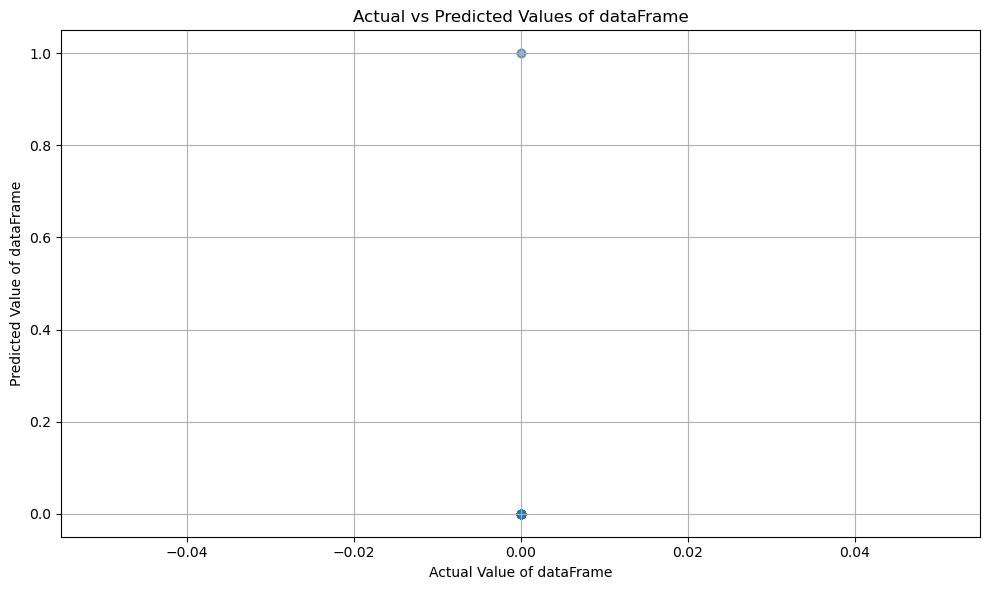

In [484]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.01)
plt.xlabel('Actual Value of dataFrame')
plt.ylabel('Predicted Value of dataFrame')
plt.title('Actual vs Predicted Values of dataFrame')
plt.grid(True)
plt.tight_layout()
plt.show()

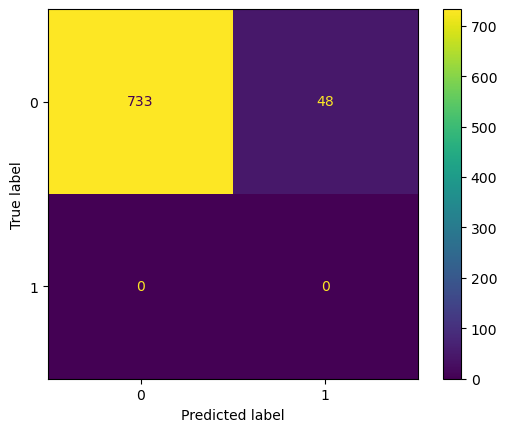

In [485]:
# Generate predictions
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [486]:
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Feature Importance:')
print(feature_importance_df)

Feature Importance:
                Feature  Importance
0            Fornecedor    0.326690
1         Valor com IVA    0.222078
2                Âmbito    0.099758
11  DayOfWeekVencimento    0.046400
5      DayOfWeekEmissão    0.046072
3                  Tipo    0.043797
10      MonthVencimento    0.042053
7          MonthEntrada    0.041249
8      DayOfWeekEntrada    0.039085
4          MonthEmissão    0.037423
12       YearVencimento    0.019405
9           YearEntrada    0.018822
6           YearEmissão    0.017166


In [487]:
# Save the model to a file
joblib.dump(model, 'random_forest_classifier.pkl')

# Load the model from the file
loaded_rfc = joblib.load('random_forest_classifier.pkl')

# Make predictions on the test data using the loaded model
y_pred = loaded_rfc.predict(X_test)

# Evaluate the loaded model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²): {r2}')

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Mean Absolute Error: 0.06145966709346991
Mean Squared Error (MSE): 0.06145966709346991
R-squared (R²): 0.0
Accuracy: 0.93854033290653
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       781
           1       0.00      0.00      0.00         0

    accuracy                           0.94       781
   macro avg       0.50      0.47      0.48       781
weighted avg       1.00      0.94      0.97       781



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [488]:
"""
# Making predictions (you can input your own data here)
new_data = pd.DataFrame({
    'Categoria_Custos': [False],
    'Categoria_Investimentos': [False],
    'Categoria_Proveitos': [False],
    'Categoria_Salários': [False],
    'Month': [6],
    'DayOfWeek': [1]
})
prediction = model.predict(new_data)
print('Predicted Value:', prediction[0])
"""

"\n# Making predictions (you can input your own data here)\nnew_data = pd.DataFrame({\n    'Categoria_Custos': [False],\n    'Categoria_Investimentos': [False],\n    'Categoria_Proveitos': [False],\n    'Categoria_Salários': [False],\n    'Month': [6],\n    'DayOfWeek': [1]\n})\nprediction = model.predict(new_data)\nprint('Predicted Value:', prediction[0])\n"